# DATA2001 Assignment 3
## Timeseries Data Analysis
### Jamie Katsamatsas s4674720
### <datehere>
    
Questions
    1. Can include other datasets with US dollar values or US GDP values and merge them into the dataset

#### Dataset Columns
- Date: Date of trades
- Open: Opening price, price of first trade of the day
- High: Highest price of all trades of the day
- Low: Lowest price of all trades of the day
- Close: Closing price, price of last trade before the end of day
- Volume: Total number of stocks traded during the day
- OpenInt: Open interest, the total number of outstanding derivative contracts, such as options or futures, that have not been settled for an asset at the end of day.

# Task 1 - Data Preparation
Read the dataset using the “pandas” library and set up the index in an appropriate way for timeseries analysis. Can you identify any useful side data or exogenous variables? If so, include them into your dataframe and handle/merge them in an appropriate way. Explain how you did it along with a justification for your choices.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
amazon_data = pd.read_csv("amzn.us.csv")
amazon_data

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0
...,...,...,...,...,...,...,...
5148,2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0
5149,2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0
5150,2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0
5151,2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978,0


In [3]:
# Rename "Date" to "Datetime"
amazon_data.rename(columns = {'Date': 'Datetime'}, inplace=True)

# set index to datetime
amazon_data = amazon_data.set_index('Datetime')

# cast "Date" to "Datetime"
amazon_data.index = amazon_data.index.astype('datetime64[ns]')

In [4]:
amazon_data.index

DatetimeIndex(['1997-05-16', '1997-05-19', '1997-05-20', '1997-05-21',
               '1997-05-22', '1997-05-23', '1997-05-27', '1997-05-28',
               '1997-05-29', '1997-05-30',
               ...
               '2017-10-30', '2017-10-31', '2017-11-01', '2017-11-02',
               '2017-11-03', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10'],
              dtype='datetime64[ns]', name='Datetime', length=5153, freq=None)

In [5]:
amazon_data.head()

,Open,High,Low,Close,Volume,OpenInt
Datetime,,,,,,
1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1997-05-19,1.76,1.77,1.62,1.71,6106800,0
1997-05-20,1.73,1.75,1.64,1.64,5467200,0
1997-05-21,1.64,1.65,1.38,1.43,18853200,0
1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [6]:
# https://www.investopedia.com/terms/p/percentage-change.asp
amazon_data["Change"] = amazon_data["Close"] - amazon_data["Open"]
amazon_data["%Change"] = amazon_data["Change"] / amazon_data["Open"]
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change
Datetime,,,,,,,,
1997-05-16,1.97,1.98,1.71,1.73,14700000,0,-0.24,-0.121827
1997-05-19,1.76,1.77,1.62,1.71,6106800,0,-0.05,-0.028409
1997-05-20,1.73,1.75,1.64,1.64,5467200,0,-0.09,-0.052023
1997-05-21,1.64,1.65,1.38,1.43,18853200,0,-0.21,-0.128049
1997-05-22,1.44,1.45,1.31,1.40,11776800,0,-0.04,-0.027778
...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0,11.51,0.010377
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0,-1.57,-0.001396
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0,10.06,0.008960


In [7]:
amazon_data.describe

<bound method NDFrame.describe of                Open     High      Low    Close    Volume  OpenInt  Change  \
Datetime                                                                    
1997-05-16     1.97     1.98     1.71     1.73  14700000        0   -0.24   
1997-05-19     1.76     1.77     1.62     1.71   6106800        0   -0.05   
1997-05-20     1.73     1.75     1.64     1.64   5467200        0   -0.09   
1997-05-21     1.64     1.65     1.38     1.43  18853200        0   -0.21   
1997-05-22     1.44     1.45     1.31     1.40  11776800        0   -0.04   
...             ...      ...      ...      ...       ...      ...     ...   
2017-11-06  1109.15  1125.41  1108.77  1120.66   3331738        0   11.51   
2017-11-07  1124.74  1130.60  1117.50  1123.17   2684443        0   -1.57   
2017-11-08  1122.82  1135.54  1119.11  1132.88   2576010        0   10.06   
2017-11-09  1125.96  1129.62  1115.77  1129.13   3729978        0    3.17   
2017-11-10  1126.10  1131.75  1124.06  112

# Task 2 - Exploratory Data Analysis
Visualise the entire data set, and comment on the patterns you can observe with respect to the features discussed in the lectures. Include visualisations appropriate for uncertainty and correlation where appropriate.

TODO
- Focus on visualise entire dataset, can visualise some shorter periods but the main focus is on all the data
- Visualise the candlestick plot in a grid with different value aggregations
- Plot all values in the dataset, can comment on that all the values result in similar plots

In [8]:
amazon_data['year'] = amazon_data.index.year
amazon_data['month'] = amazon_data.index.month_name()
amazon_data['day'] = amazon_data.index.day_name()

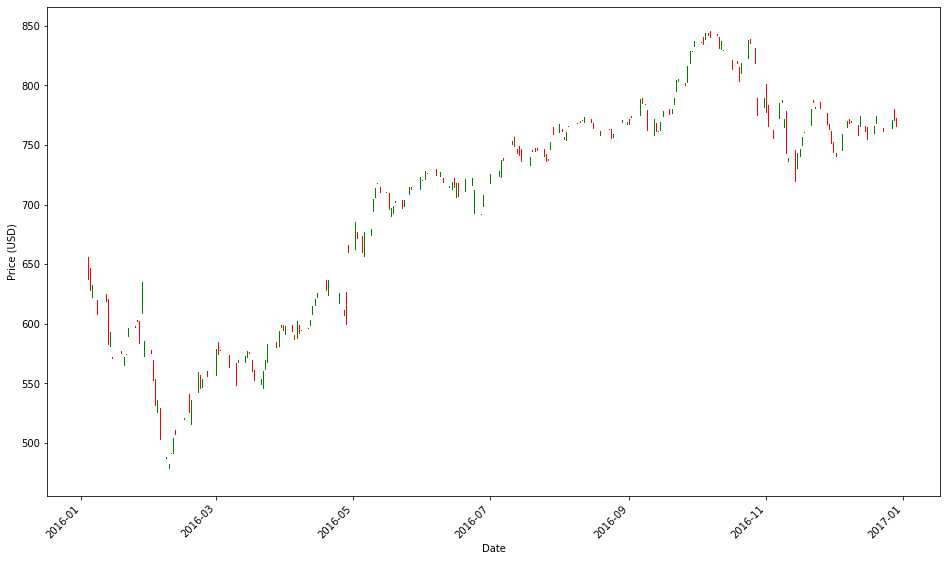

In [9]:
# https://www.statology.org/matplotlib-python-candlestick-chart/

time_period_start = "2016-01-01"
time_period_end = "2017-01-01"

amazon_data_chunk = amazon_data[time_period_start:time_period_end]

plt.figure(figsize=(16,9))

width = 0.4
width2 = 0.05

up = amazon_data_chunk[amazon_data_chunk['Close'] >= amazon_data_chunk['Open']]
down = amazon_data_chunk[amazon_data_chunk['Close'] < amazon_data_chunk['Open']]

# plt.plot(down.index, down["Close"], color='yellow')

# plot up prices
plt.bar(up.index, up["Close"] - up["Open"], width, bottom=up["Open"], color='green')
plt.bar(up.index, up["High"] - up["Close"], width2, bottom=up["Close"], color='green')
plt.bar(up.index, up["Low"] - up["Open"], width2, bottom=up["Open"], color='green')

# plot down prices
plt.bar(down.index, down["Close"] - down["Open"], width, bottom=down["Open"], color='red')
plt.bar(down.index, down['High'] - down["Open"], width2, bottom=down["Open"], color='red')
plt.bar(down.index, down["Low"] - down["Close"], width2, bottom=down["Close"], color='red')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.xlabel('Date')
plt.ylabel('Price (USD)')

#display candlestick chart
plt.show()

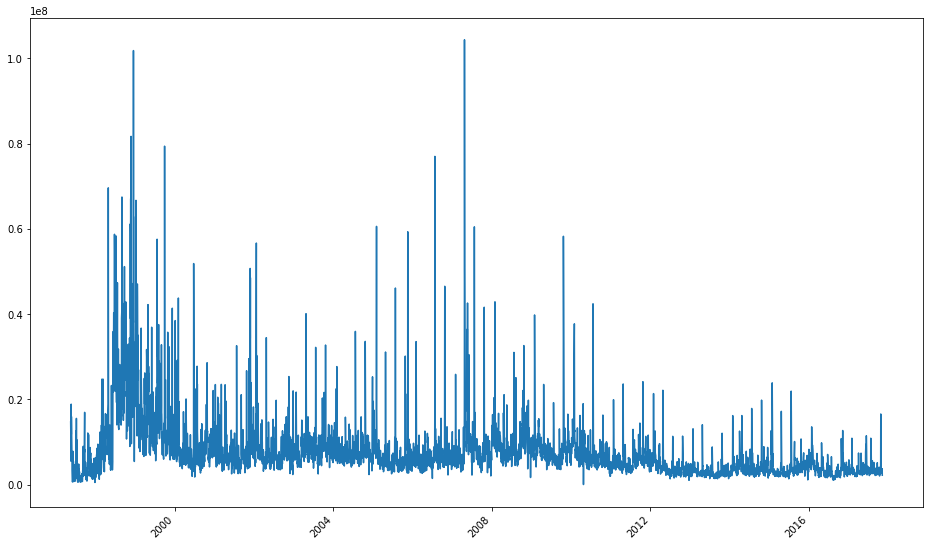

In [10]:
# plot Volume
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["Volume"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

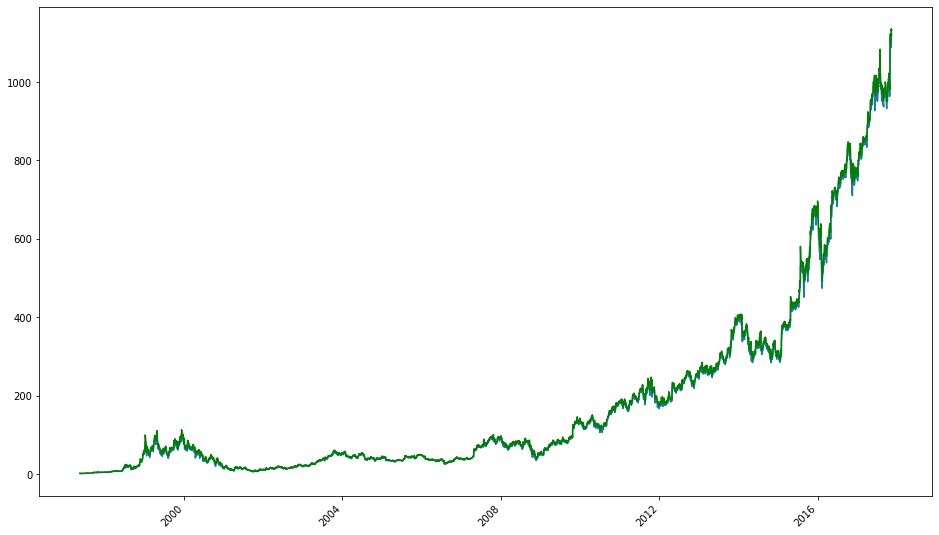

In [11]:
# plot Low, High
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["Low"])
plt.plot(amazon_data.index, amazon_data["High"], 'green')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

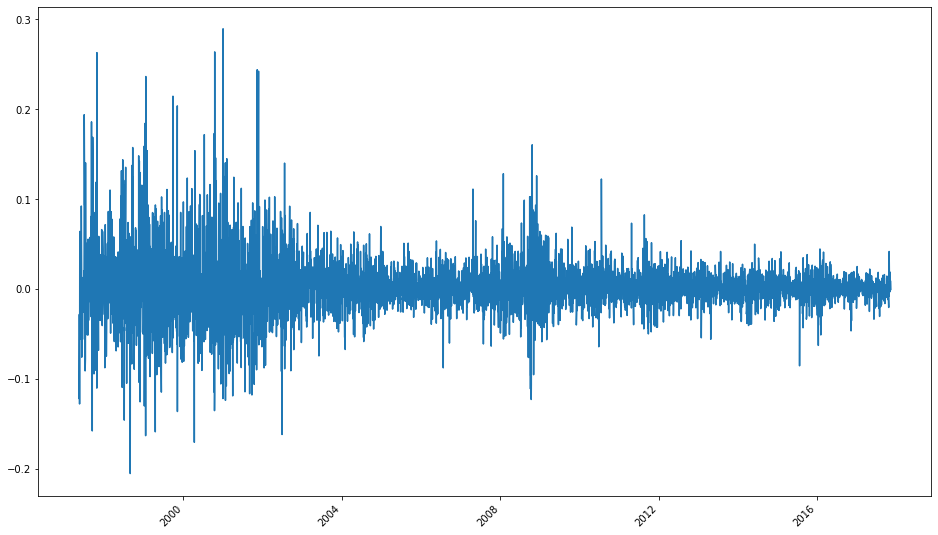

In [12]:
# plot %change
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["%Change"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

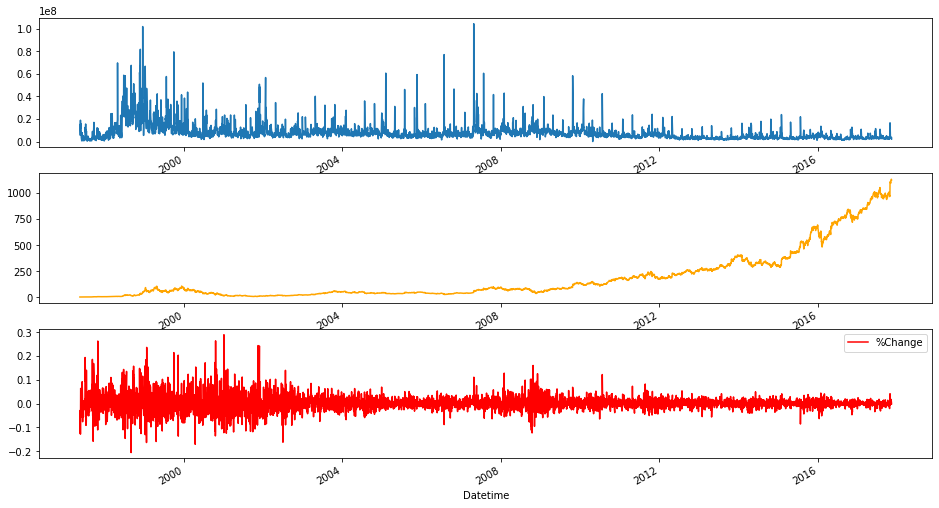

In [13]:
# Plot volume
fig, ax = plt.subplots(3)
amazon_data["Volume"].plot(label='Volume', ax=ax[0])
amazon_data["Close"].plot(color='orange', label='Close', ax=ax[1])
amazon_data["%Change"].plot(color='red', label='%Change', ax=ax[2])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

Text(0, 0.5, 'Volume')

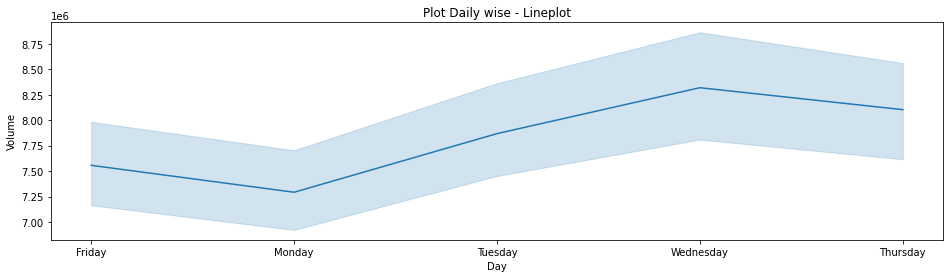

In [14]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='day', y=amazon_data['Volume'], ax=axes[0,0])
axes[0,0].set_title("Plot Daily wise - Lineplot")
axes[0,0].set_xlabel('Day')
axes[0,0].set_ylabel('Volume')

Text(0, 0.5, 'Volume')

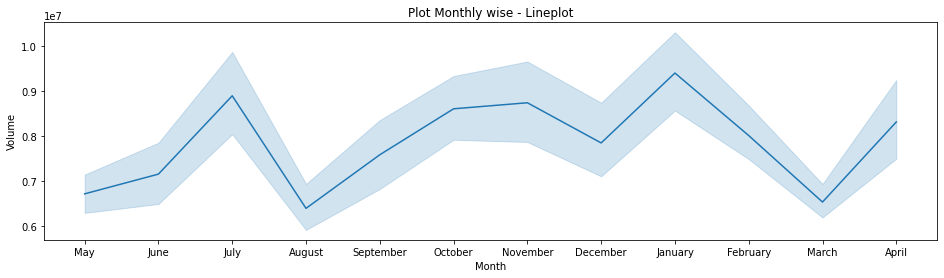

In [15]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='month', y=amazon_data['Volume'], ax=axes[0,0])
axes[0,0].set_title("Plot Monthly wise - Lineplot")
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Volume')

Text(0, 0.5, 'Volume')

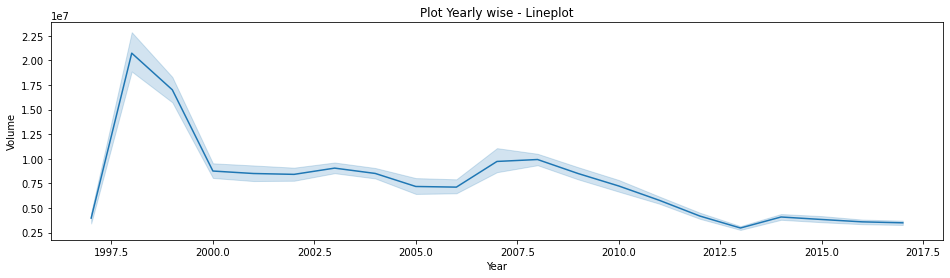

In [16]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='year', y=amazon_data['Volume'], ax=axes[0,0])
axes[0,0].set_title("Plot Yearly wise - Lineplot")
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Volume')

Text(0, 0.5, 'Volume')

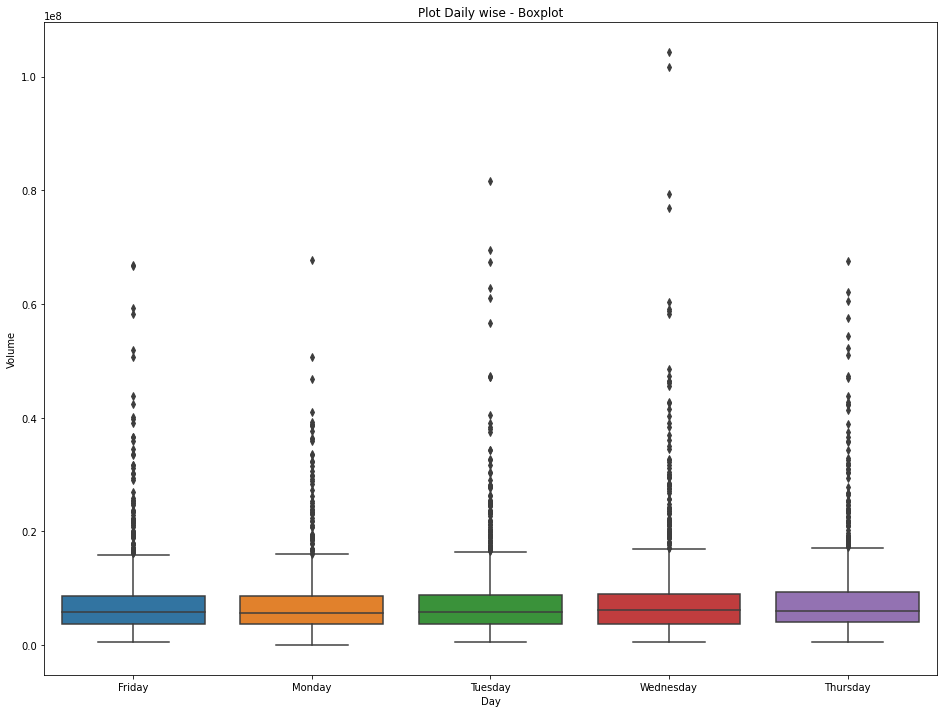

In [17]:
# Boxplot to view daily volume 
fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(data=amazon_data, x='day', y=amazon_data['Volume'], ax = ax)
ax.set_title("Plot Daily wise - Boxplot")
ax.set_xlabel('Day')
ax.set_ylabel('Volume')

Text(0, 0.5, 'Volume')

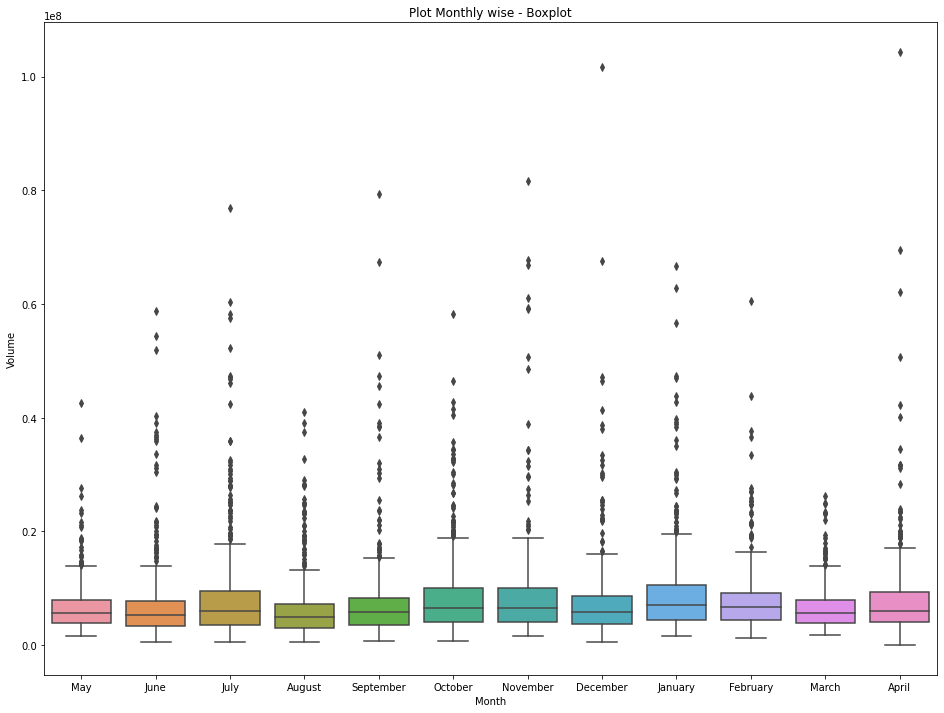

In [18]:
# Boxplot to view monthly volume 
fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(data=amazon_data, x='month', y=amazon_data['Volume'], ax = ax)
ax.set_title("Plot Monthly wise - Boxplot")
ax.set_xlabel('Month')
ax.set_ylabel('Volume')

Text(0, 0.5, 'Volume')

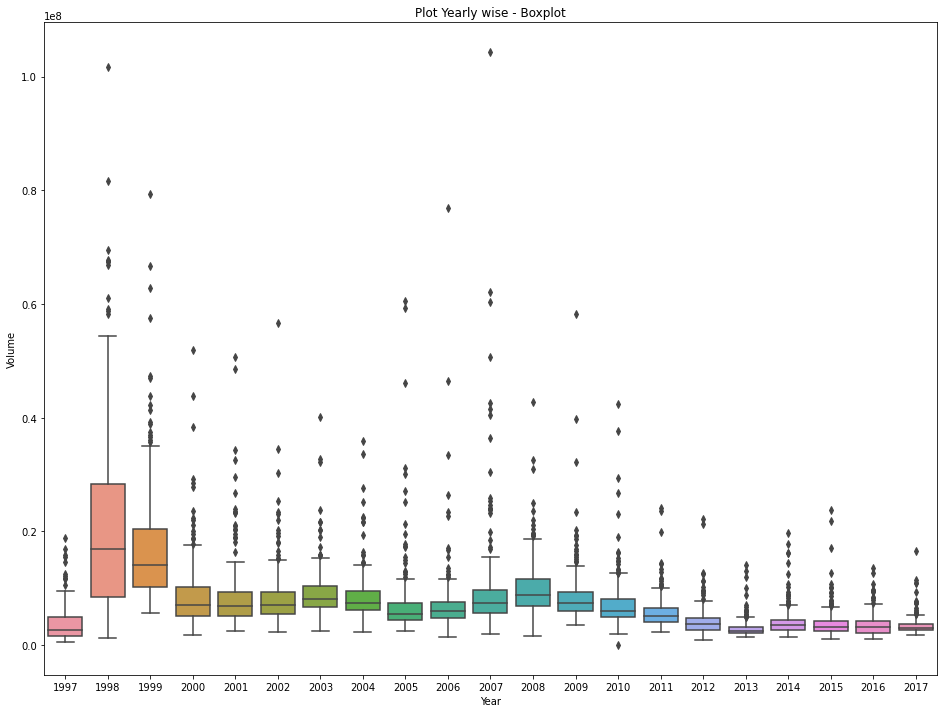

In [19]:
# Boxplot to view yearly volume 
fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(data=amazon_data, x='year', y=amazon_data['Volume'], ax = ax)
ax.set_title("Plot Yearly wise - Boxplot")
ax.set_xlabel('Year')
ax.set_ylabel('Volume')

# Task 3 - AMZN STR Decomposition
Focus now on the AMZN stock volume time series.

a) Split the data into training and testing series, selecting the testing series to be the last three months of the data.

b) Manually step through the STR decomposition process on the training data, as
described in the course material. Visualise and interpret each of the components of the STR decomposition for volume. (Hint: You may wish to validate the output of your manual process against an automated modelling approach.)

In [20]:
# Remove all data besides stock volume data
amazon_data.drop(amazon_data.columns.difference(['Datetime', 'Volume']), axis=1, inplace=True)

div = 5 * 4 * 3 # 5 days a week * 4 weeks a month * 3 months
train_amazon = amazon_data['Volume'][:-div]
test_amazon = amazon_data['Volume'][-div:]

### Isolate Trend

In [63]:
amazon_data['MA5 Trend'] = amazon_data['Volume'].rolling(5).mean() # 1 week
amazon_data['MA20 Trend'] = amazon_data['Volume'].rolling(20).mean() # 1 month
amazon_data['MA60 Trend'] = amazon_data['Volume'].rolling(60).mean() # 3 months
amazon_data['MA120 Trend'] = amazon_data['Volume'].rolling(120).mean() # 6 months
amazon_data['MA180 Trend'] = amazon_data['Volume'].rolling(180).mean() # 9 months
amazon_data['MA240 Trend'] = amazon_data['Volume'].rolling(240).mean() # 12 months
amazon_data['MA480 Trend'] = amazon_data['Volume'].rolling(480).mean() # 24 months
amazon_data['MA720 Trend'] = amazon_data['Volume'].rolling(720).mean() # 36 months

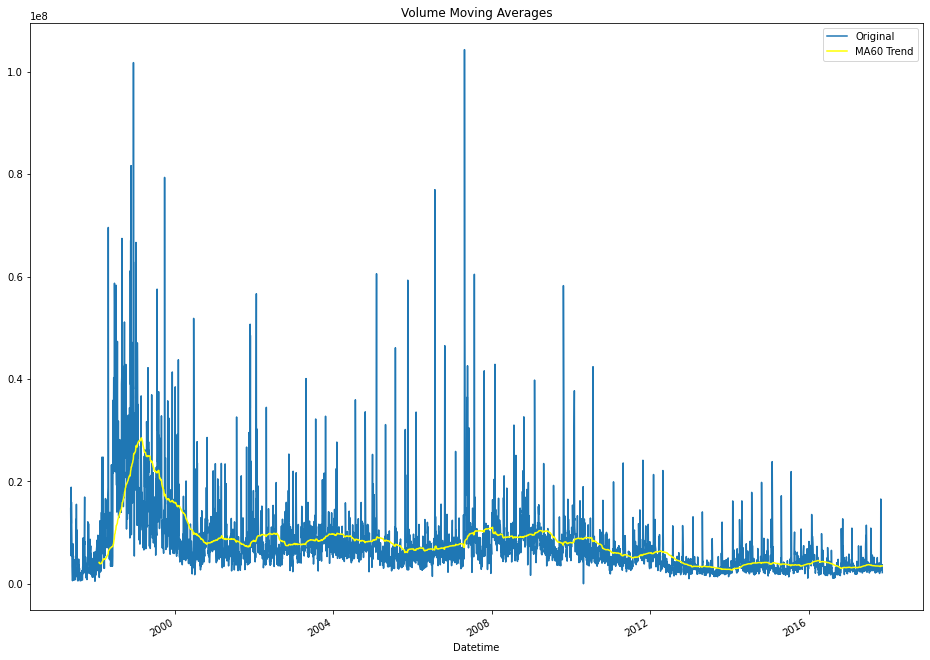

In [72]:
fig, ax = plt.subplots()
amazon_data['Volume'].plot(label='Original', ax=ax)
# amazon_data['MA5 Trend'].plot(color='red', label='MA5 Trend', ax=ax)
# amazon_data['MA20 Trend'].plot(color='green', label='MA20 Trend', ax=ax)
# amazon_data['MA60 Trend'].plot(color='orange', label='MA60 Trend', ax=ax)
# amazon_data['MA120 Trend'].plot(color='blue', label='MA60 Trend', ax=ax)
amazon_data['MA180 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
# amazon_data['MA240 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
# amazon_data['MA480 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
# amazon_data['MA720 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
plt.title('Volume Moving Averages')
fig.set_size_inches((16, 12))
plt.legend()
plt.show()

### Detrend the Series

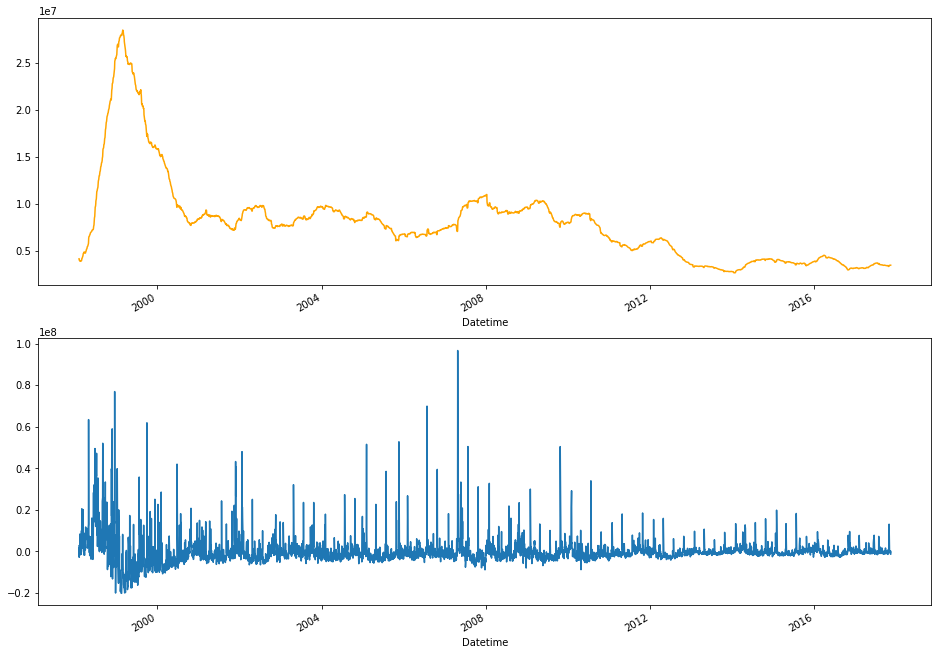

In [75]:
# De-trended data
amazon_data['De-trended'] = amazon_data['Volume'] - amazon_data['MA180 Trend']

fig, ax = plt.subplots(2)
amazon_data['MA180 Trend'].plot(color='orange', label='MA180 Trend', ax=ax[0])
amazon_data['De-trended'].plot(label='De-trended', ax=ax[1])
fig.set_size_inches((16, 12))
plt.show()

### Estimate seasonal component

In [ ]:
raw_detrend_means = amazon_data.groupby(amazon_data.index.month)['De-trended'].mean()
adjustment

# Task 4 - Timeseries Models
a) Fit an ARIMA model for the trend-cycle component of your STR decomposition of the training data and interpret the estimated model parameters.

b) Using the STR components that you estimated in tasks 3 and 4, produce forecasts of AMZN stock volumes for the test data series. Include the uncertainty in the forecasts and visualise the predictions.

# Task 5 - Pure Forcasters
now consider your choice of ML techniques

a) Select an appropriate pure forecasting method to predict the trend component of the volume training data.

b) Using the seasonal component that you estimated in task 3 and the pure forecaster from 5.a, produce forecasts of AMZN stock volumes for the test data series. Include the uncertainty in the forecasts, and visualise the predictions.

# Task 6 - Model Evaluation
Evaluate the forecast performance of your model-based and pure forecasters using the test data and compare the two forecasters. Use appropriate evaluation metrics and methods. Discuss the similarities and difference between their performance and suggest possible avenues for improvement.